In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

In [39]:
cadr=42

In [40]:
n = 5 # размерность сетки
mat = np.zeros((n * n, n * n), dtype=int)
for i in range(n):
    for j in range(n):
        row = n * j + i
        if i == 0 or i == n - 1 or j == 0 or j == n - 1:
            mat[row][row] = 1
        else:
            mat[row][n * j + i] = 2
            mat[row][n * j + (i - 1)] = 3
            mat[row][n * j + (i + 1)] = 3
            mat[row][n * (j - 1) + i] = 3
            mat[row][n * (j + 1) + i] = 3
            
print(mat)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 

In [158]:
def transform(A, b):
    m = len(A)
    B = np.zeros((m, m))
    C = np.zeros(m)
    for i in range(m):
        for j in range(m):
            if i == j:
                B[i][j] = 0
            else:
                B[i][j] = - A[i][j] / A[i][i]
    for i in range(m):
        C[i] = b[i] / A[i][i]

    return B, C


def seidel_solve(B, C, x):
    m = len(x)
    result = np.zeros(m)
    for i in range(m):
        s = 0
        for j in range(i):
            s += B[i][j] * result[j]
        for j in range(i, m):
            s += B[i][j] * x[j]
        result[i] = s + C[i]
    return result


def Seidel(A, b, eps):
    B, C = transform(A, b)
    x = np.zeros(len(A))
    y = seidel_solve(B, C, x)
    n = 1
    r0 = np.linalg.norm(A @ x - b)
    rn = np.linalg.norm(A @ y - b)
    while rn / r0 > eps and n < 200:
        x = y
        y = seidel_solve(B, C, x)
        rn = np.linalg.norm(A @ y - b)
        n += 1
    return y

In [200]:
T = 0.1
field_size = 100
time_duration = 100

t = T / time_duration
h = 1 / field_size
u = np.zeros((field_size, field_size, int(T / t)))
eps = 10 ** -5

In [201]:
def phi(x, y):
    return 0

def g(x, y, t):
    return 0.1

In [202]:
# Ника сделать это по человечески, рассмотреть все граничные условия дял матрицы и переписать весь код по человечсеский
def generate_matrix(n, h, t):
    A = np.zeros((n * n, n * n))
    for i in range(n):
        for j in range(n):
            row = n * j + i
            if i == 0 or i == n - 1 or j == 0 or j == n - 1:
                A[row][row] = 1
            else:
                A[row][n * j + i] = (h ** 2 + 4 * t)
                A[row][n * j + (i - 1)] = -t
                A[row][n * j + (i + 1)] = -t
                A[row][n * (j - 1) + i] = -t
                A[row][n * (j + 1) + i] = -t
    return A

def generate_b(u, n, h, t, k):
    b = np.zeros(n * n)
    for i in range(n):
        for j in range(n):
            row = j * n + i
            if i == 0 or i == n - 1 or j == 0 or j == n - 1:
                b[row] = g(i * h, j * h, k * t)
            else:
                b[row] = h ** 2 * u[i][j][k]
    return b

In [203]:
def solve():
    A = generate_matrix(field_size, h, t)
    # np.set_printoptions(threshold=np.inf)
    # print(A)

    for k in range(0, int(T / t)):
        if k == 0:
            for i in range(field_size):
                for j in range(field_size):
                    if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
                        u[i][j][k] = g(i * h, j * h, 0)
                    else:
                        u[i][j][k] = phi(i * h, j * h)
        else:            
            b = generate_b(u, field_size, h, t, k - 1)
            # print(b)
            # np.set_printoptions(threshold=np.inf, linewidth=np.inf)
            # print(A)
            y = spsolve(csr_matrix(A), b)
            # y = Seidel(A, b, eps)
            for i in range(field_size):
                for j in range(field_size):
                    u[i][j][k] = y[j * field_size + i]
                    

In [204]:
solve()

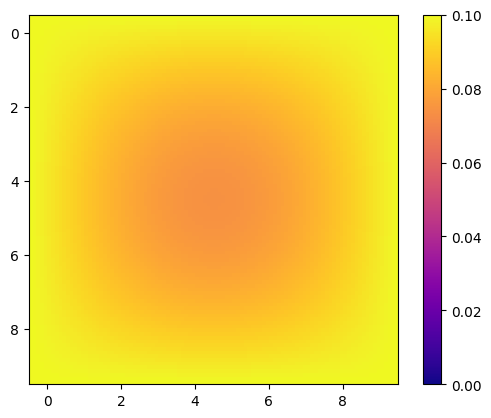

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Задаем параметры
frames = time_duration - 10  # Количество кадров анимации
interval = 100  # Интервал между кадрами в миллисекундах
 
# Создание фигуры и оси
fig, ax = plt.subplots()

data = np.random.rand(10, 10)

# Создание начальной тепловой карты
heatmap = ax.imshow(data, cmap='plasma', interpolation='nearest', vmin = 0, vmax = 0.1)

# Функция обновления для анимации
k = 0

def update(frame):
    global k
    heatmap.set_array(u[:, :, k])
    k += 1
    # print(u[:, :, k])
    return [heatmap]

plt.colorbar(heatmap)

# Создание анимации

ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(f'tryis delete after/animation{cadr}.gif', writer=PillowWriter(fps=10))
cadr += 1
